## Sentinel-2 - Landsat 8 Harmonization

This notebook describes the application of some harmonization algorithms on Landsat 8 datasets with Sentinel-2 for time series analysis. These algoriths were developed by the NASA's 'Harmonized Landsat Sentinel-2' project. For this work, two of the project algorithms were adapted to be applied in Landsat-8 images.
1. [Band-pass adjustment](https://hls.gsfc.nasa.gov/algorithms/bandpass-adjustment/)
2. Co-registration

The earth observation images used in this examples correpond to BOA subsets of two Level-2 images corresponding to the region of Saldaña, Colombia acquired in December 21st and 22nd, 2015 were corrected using the algorithms. Sentinel-2 images was processed with sen2cor tool provided by ESA. For Landsat, Level-2 images acquired from USGS L8 OLI Collections Land Surface Reflectance.

| Mission | ID | Sensor | Acq. Date |
| --- | --- | --- | --- |
| Sentinel-2 | S2A_USER_PRD_MSIL2A_PDMC_20151222T172432_R025_V20151221T153336_20151221T153336 | MSI | 2015-12-21 |
| Landsat 8 | LC080080572015122201T1-SC20180522114337 | OLI | 2015-12-22 |


In [1]:
# Start local cluster for multi core processing
from dask.distributed import Client
client = Client(n_workers=12)
client

<Client: scheduler='tcp://127.0.0.1:33171' processes=12 cores=24>

### Band Pass Adjustment

To correct band-pass differences for optical bands between OLI and MSI sensors, a linear function. The following table shows the linear function coefficients for the correction of MSI values for each band.

$$OLI = B_1 * MSI + B_0 + \epsilon$$

|Band Name | Slope (B<sub>1</sub>) | Offset (B<sub>0</sub>) | Residual ($\epsilon$)|
|---|---|---|---|
|Coastal aerosol|0.996|-0.00023|0.0004|
|Blue|0.977|-0.00411|0.0018|
|Green|1.005|-0.00093|0.0011|
|Red|0.982|0.00094|0.0015|
|NIR|1.001|-0.00029|0.0003|
|SWIR 1|1.001|-0.00015|0.0001|
|SWIR 2|0.996|-0.00097|0.0009|

To obtain the correction of OLI images to match MSI, the linear function were inverted, then the following function was applied on Landsat 8 dataset.

$$MSI = \frac{1}{B_1} * OLI - \frac{B_0}{B_1} + \epsilon$$

Results of the evaluation are mixed, as the error seems to decrease for some bands, while for others remain similar. None of the error distributions were dramatically changed. As the evaluation is made on images obtained with a difference of one day, we can attribute some part of the error to land use changes that occured in that time frame.

The correction in both sensors (MSI using OLI and OLI using MSI) yielded similar changes in error correction.

In [2]:
# Import packages
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd

sys.path.append('../b_Temporal_Stack')

import regionstack
import eotempstack

In [3]:
# Load datasets as xr.Dataset
saldana = regionstack.regionStack('Saldana2', attrs=['S2', 'LC08'], ignore_harm=True)

S2 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana2/pre/
Reading 3 S2 stack files
LC08 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana2/pre/
Reading 9 LC08 stack files


In [10]:
# Subset dates of analysis
s2 = saldana.S2.sel(time='2015-12-21')
l8 = saldana.LC08.sel(time='2015-12-22')

oli = '2015-12-22'
msi = '2015-12-21'

In [11]:
# Concatenate the two datasets in time dimension
time = xr.Variable('time', pd.Index(np.array([s2.time.values, l8.time.values])))
da = xr.concat([s2, l8], dim=time)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


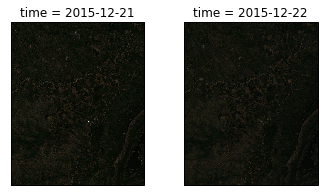

In [58]:
# Visualize dataset (MSI:2015-12-21, OLI:2015-12-22)
da.eotemp.plot_RGB()

In [12]:
## Utility functions to visualize error in band-pass correction
from matplotlib import pyplot as plt

def correct_band(dataset, band):
    
    lf_dict = {'blue':[0.977, -0.00411],'green':[1.005, -0.00093],
               'red':[0.982, 0.00094],'nir':[1.001, -0.00029],
               'swir1':[1.001,-0.00015],'swir2':[0.996,-0.00097]}
    
    # Compute original difference
    orig_diff = (dataset[band].sel(time=oli) - dataset[band].sel(time=msi))*0.0001
    
    # Calculate error mean and sd
    orig_error_mean = orig_diff.mean(dim=['x','y']).compute()*0.0001
    orig_error_sd = orig_diff.std(dim=['x','y']).compute()*0.0001
    
    # Apply correction B_0 * BOA + B_1
    dataset[band+'_corr'] = lf_dict[band][0]*dataset[band]+lf_dict[band][1]
    
    # Calculate the difference with corrected band 
    corr_diff = (dataset[band].sel(time=oli) - dataset[band+'_corr'].sel(time=msi))*0.0001
    
    corr_error_mean = corr_diff.mean(dim=['x','y']).compute()*0.0001
    corr_error_sd = corr_diff.std(dim=['x','y']).compute()*0.0001
    
    print('{} original: {} +- {}'.format(band, orig_error_mean.values+0, orig_error_sd.values*2))
    print('{} corected: {} +- {}'.format(band, corr_error_mean.values+0, corr_error_sd.values*2))
    
    # Plot differences
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize= (12, 7))
    # Histograms
    xr.plot.hist(orig_diff, bins=75, alpha=0.75, facecolor='blue', range=(-0.5,0.5), ax=axes[0,0])
    xr.plot.hist(corr_diff, bins=75, alpha=0.75, facecolor='green', range=(-0.5,0.5), ax=axes[0,1])
    # Maps
    orig_diff.plot(robust=True, ax=axes[1,0], cmap='viridis')
    corr_diff.plot(robust=True, ax=axes[1,1], cmap='viridis')
    
    axes[0,0].set_title('Original error OLI-MSI {} band'.format(band))
    axes[0,1].set_title('Corrected error OLI-MSI {} band'.format(band))
    axes[1,0].set_title('Original error plot OLI-MSI {} band'.format(band))
    axes[1,1].set_title('Corrected error plot OLI-MSI {} band'.format(band))
    
    plt.tight_layout()
    plt.show()
    
def correct_band_inv(dataset, band):
    
    lf_dict = {'blue':[1.0/0.977, -0.00411/-0.977],'green':[1.0/1.005, -0.00093/-1.005],
               'red':[1.0/0.982, 0.00094/-0.982],'nir':[1.0/1.001, -0.00029/-1.001],
               'swir1':[1.0/1.001,-0.00015/-1.001],'swir2':[1.0/0.996,-0.00097/-0.996]}
    
    # Compute original difference
    orig_diff = (dataset[band].sel(time=oli) - dataset[band].sel(time=msi))*0.0001
    
    # Calculate error mean and sd
    orig_error_mean = orig_diff.mean(dim=['x','y']).compute()*0.0001
    orig_error_sd = orig_diff.std(dim=['x','y']).compute()*0.0001
    
    # Apply correction
    dataset[band+'_corr_inv'] = lf_dict[band][0]*dataset[band]+lf_dict[band][1]
    
    # Calculate the difference with corrected band
    corr_diff = (dataset[band+'_corr_inv'].sel(time=oli) - dataset[band].sel(time=msi))*0.0001
    
    corr_error_mean = corr_diff.mean(dim=['x','y']).compute()*0.0001
    corr_error_sd = corr_diff.std(dim=['x','y']).compute()*0.0001
    
    print('{} original: {} +- {}'.format(band, orig_error_mean.values+0, orig_error_sd.values*2))
    print('{} corected: {} +- {}'.format(band, corr_error_mean.values+0, corr_error_sd.values*2))
    
    # Plot differences
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize= (12, 7))
    # Histograms
    xr.plot.hist(orig_diff, bins=75, alpha=0.75, facecolor='blue', range=(-0.5,0.5), ax=axes[0,0])
    xr.plot.hist(corr_diff, bins=75, alpha=0.75, facecolor='green', range=(-0.5,0.5), ax=axes[0,1])
    # Maps
    orig_diff.plot(robust=True, ax=axes[1,0], cmap='viridis')
    corr_diff.plot(robust=True, ax=axes[1,1], cmap='viridis')
    
    axes[0,0].set_title('Original error OLI vs. MSI {} band'.format(band))
    axes[0,1].set_title('Corrected error OLI vs. MSI {} band'.format(band))
    axes[1,0].set_title('Original error plot OLI vs. MSI {} band'.format(band))
    axes[1,1].set_title('Corrected error plot OLI vs. MSI {} band'.format(band))
    
    plt.tight_layout()
    plt.show()
    

red original: -1.3052537694770382e-07 +- 3.3923396469977232e-06
red corected: -8.717282805605813e-09 +- 3.3232752100420345e-06


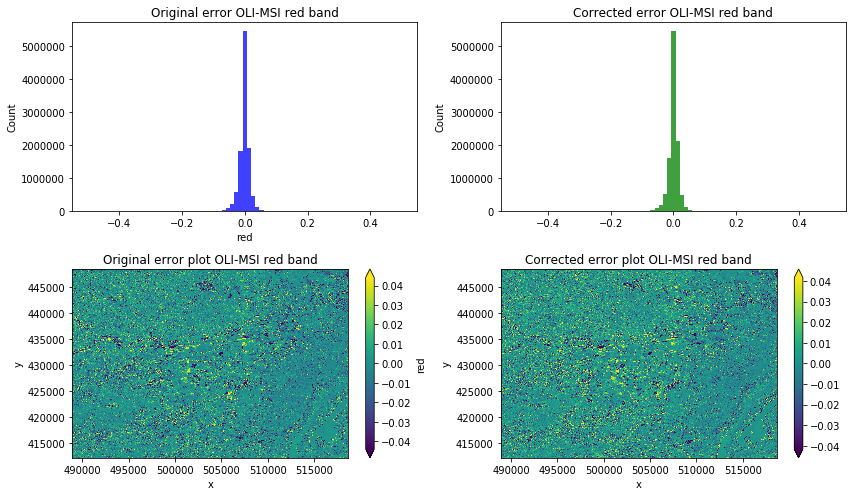

In [60]:
correct_band(da, 'red')

red original: -1.3052537694770382e-07 +- 3.3923396469977232e-06
red corected: -8.877070066808951e-09 +- 3.384190641590667e-06


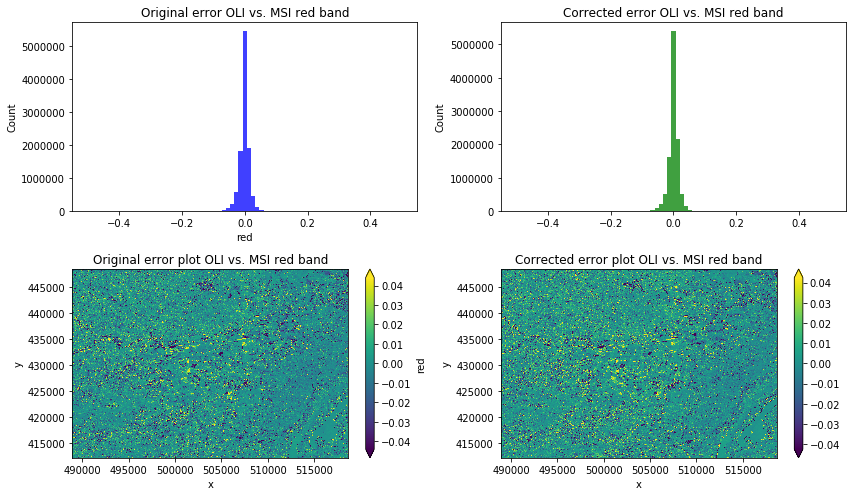

In [61]:
correct_band_inv(da,'red')

green original: -2.2589451102420643e-07 +- 2.6180992145344137e-06
green corected: -2.632264194323584e-07 +- 2.6328350929387063e-06


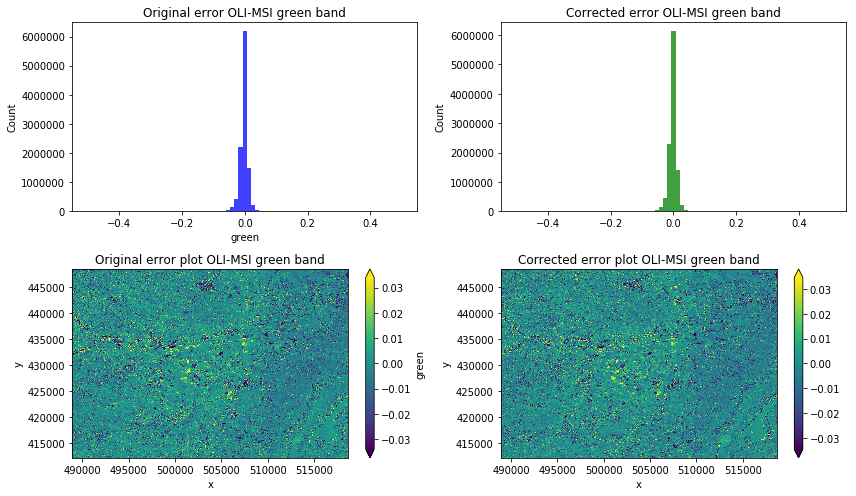

In [13]:
correct_band(da, 'green')

green original: -2.2589451102420643e-07 +- 2.6180992145344137e-06
green corected: -2.6191683525607787e-07 +- 2.6197364108842836e-06


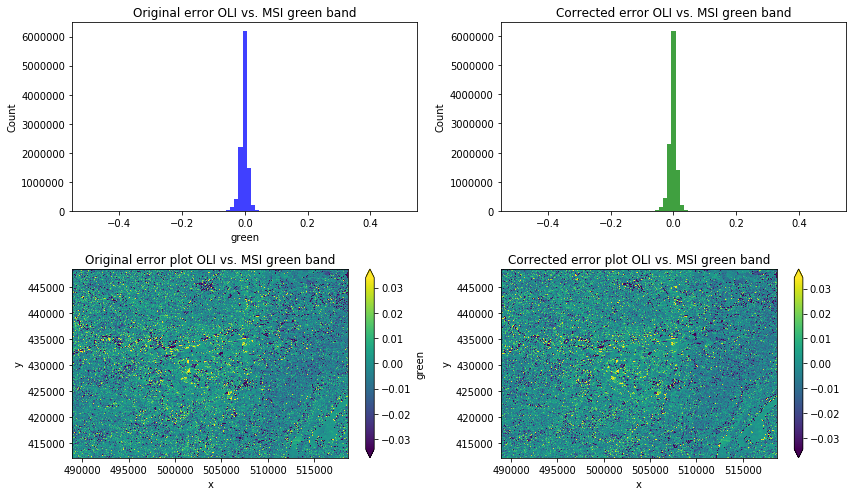

In [14]:
correct_band_inv(da, 'green')

blue original: 2.1319634478775618e-07 +- 2.523706293754454e-06
blue corected: 3.114220447283707e-07 +- 2.458117577031471e-06


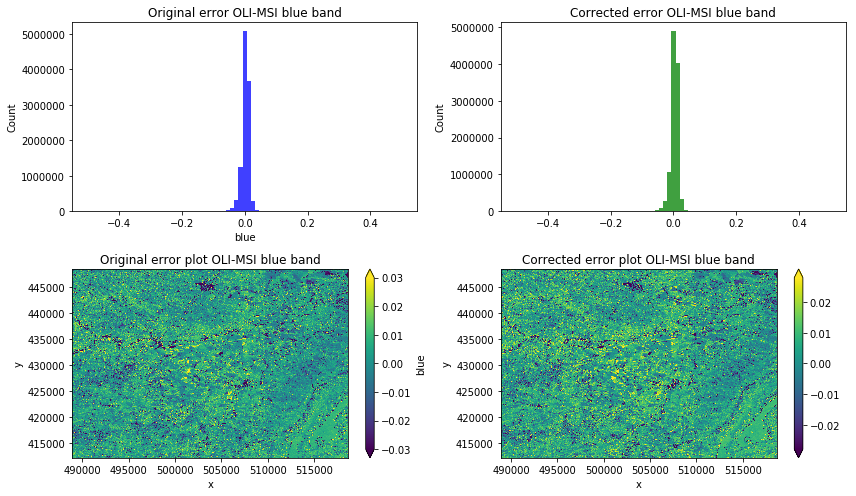

In [15]:
correct_band(da, 'blue')

blue original: 2.1319634478775618e-07 +- 2.523706293754454e-06
blue corected: 3.1875337229106495e-07 +- 2.515985237493828e-06


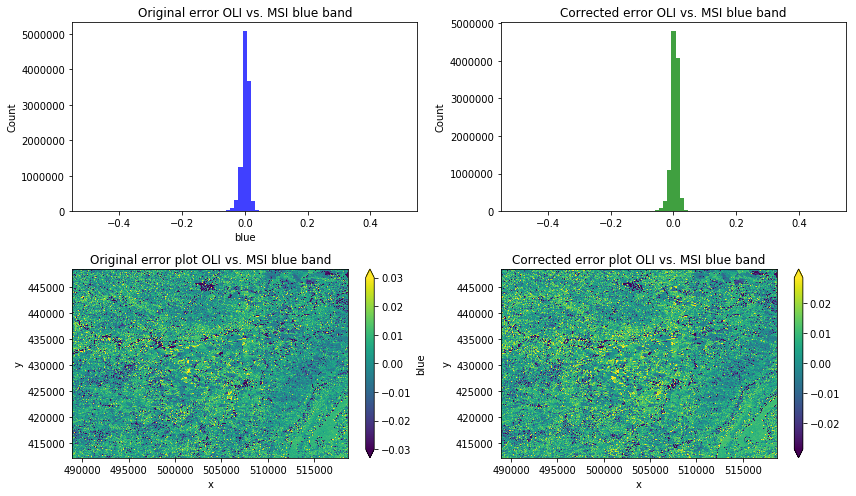

In [16]:
correct_band_inv(da, 'blue')

nir original: 2.5228443699041273e-06 +- 6.318171111844297e-06
nir corected: 2.495182553305298e-06 +- 6.320500592407709e-06


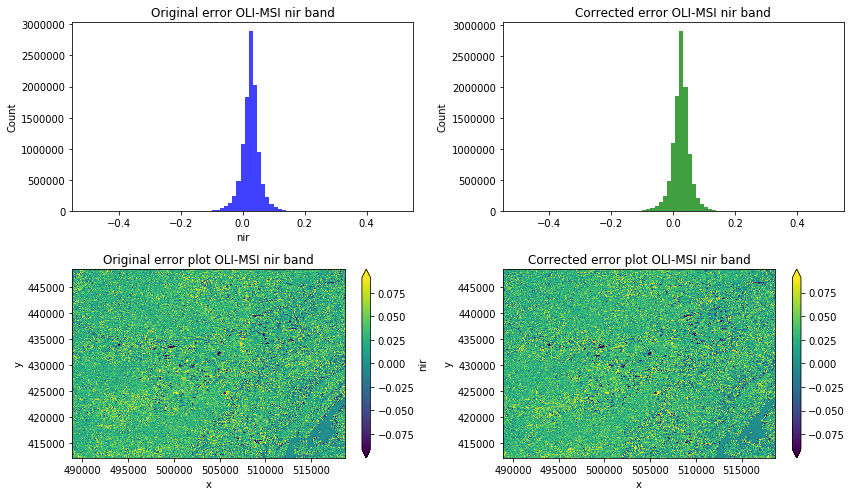

In [17]:
correct_band(da, 'nir')

nir original: 2.5228443699041273e-06 +- 6.318171111844297e-06
nir corected: 2.4926898634418577e-06 +- 6.3141864060017115e-06


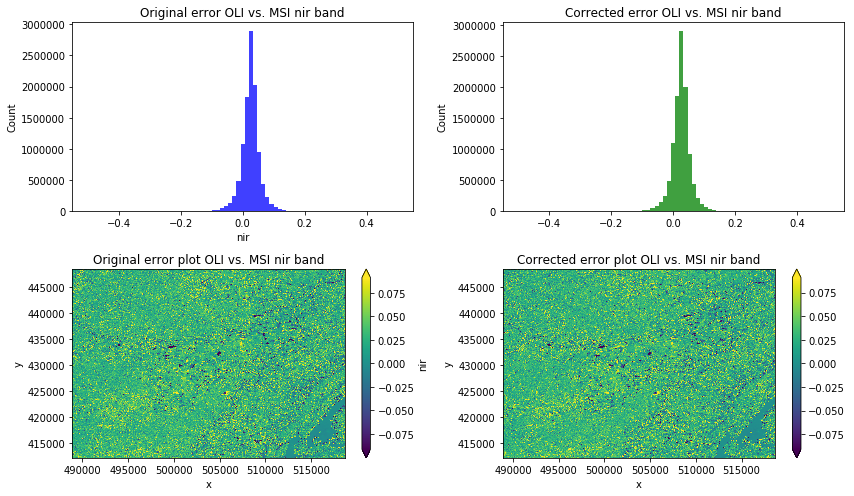

In [18]:
correct_band_inv(da, 'nir')

swir1 original: -1.6012434925077834e-06 +- 5.520038628322652e-06
swir1 corected: -1.625275103344075e-06 +- 5.52446547287689e-06


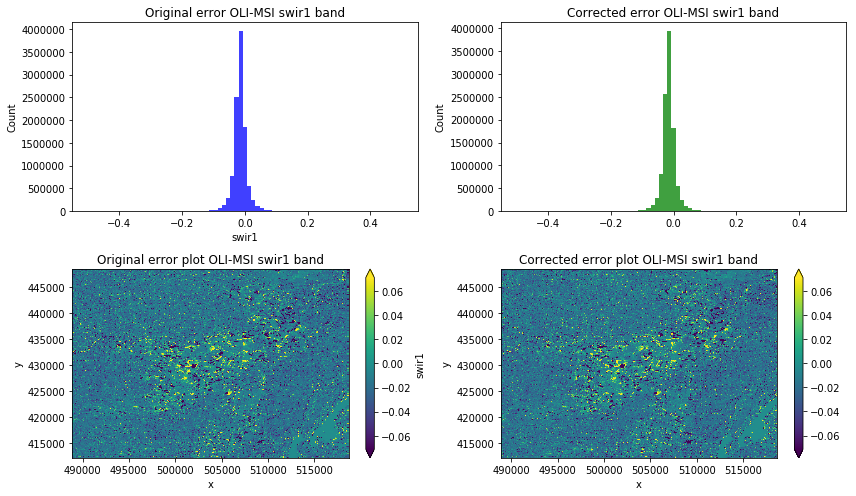

In [19]:
correct_band(da, 'swir1')

swir1 original: -1.6012434925077834e-06 +- 5.520038628322652e-06
swir1 corected: -1.623651451892182e-06 +- 5.518946526350537e-06


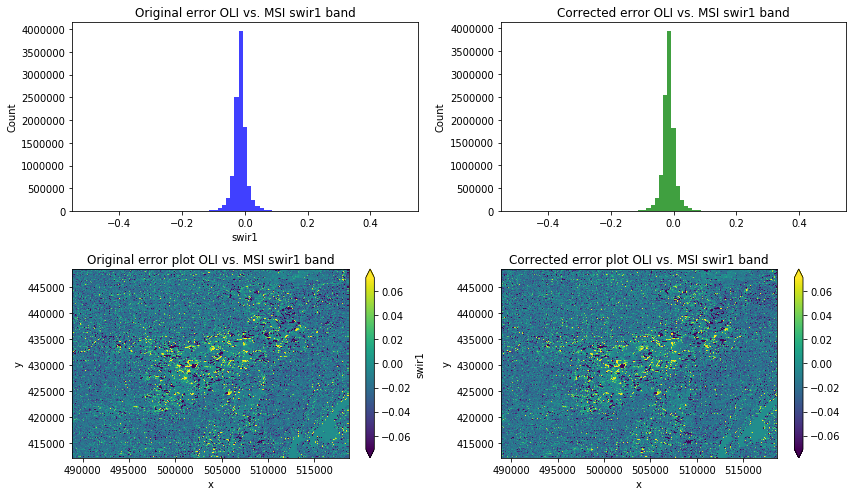

In [20]:
correct_band_inv(da, 'swir1')

swir2 original: -1.992608972559016e-06 +- 4.702242452282931e-06
swir2 corected: -1.933330013427384e-06 +- 4.676932718289586e-06


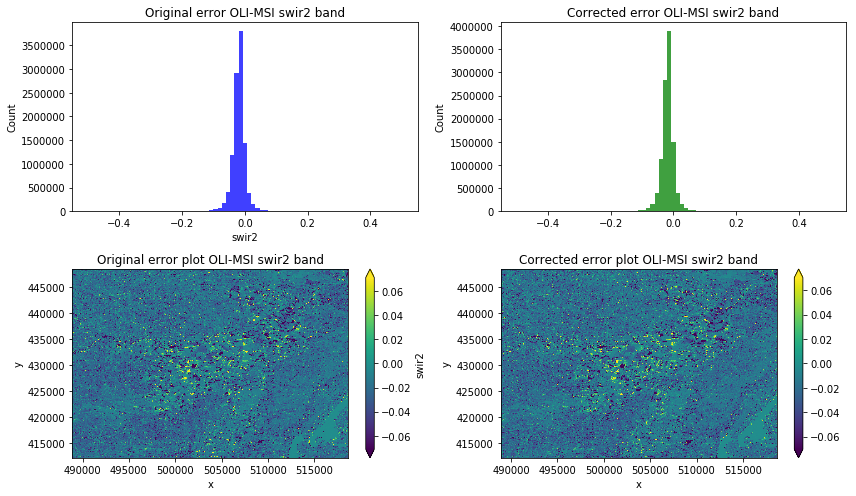

In [21]:
correct_band(da, 'swir2')

swir2 original: -1.992608972559016e-06 +- 4.702242452282931e-06
swir2 corected: -1.9410943909913484e-06 +- 4.695715580612032e-06


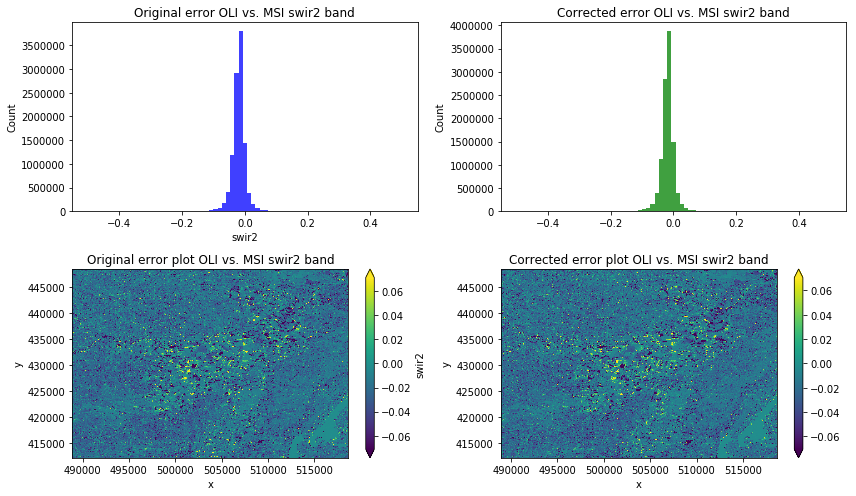

In [22]:
correct_band_inv(da, 'swir2')

### Co-registration

The approach to correct small co-registration errors is using the [register translation](http://scikit-image.org/docs/dev/auto_examples/transform/plot_register_translation.html) method in skimage, which uses cross-correlation to identify the relative shift between two images.

The relative shift calculation is by default performed using the red band for the dates with the least cloud cover in the dataset.

After the shif identification, the Landsat-8 imaged is warped to match the Sentinel-2 image using a nearest-neighbour (0-order) correction. Please note that this method and level of correction is not able to correct sub-pixel co-registration errors.

To check corregistration we export an RGB image, using two Sentinel-2 bands and one Landsat-8 band image.

In [6]:
image = np.nan_to_num(da.sel(time=msi).red.data.compute())
print(image.shape)
offset_image = np.nan_to_num(da.sel(time=oli).red.data.compute())
print(offset_image.shape)

(3635, 2981)
(3635, 2981)


In [7]:
from skimage.feature import register_translation
from skimage.transform import SimilarityTransform
from skimage.transform import warp

In [8]:
# Calculate offset with pixel precision
shift, error, diffphase = register_translation(image, offset_image)

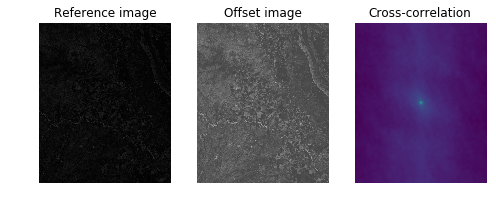

Detected pixel offset (y, x): [3. 1.]


In [14]:
fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print("Detected pixel offset (y, x): {}".format(shift))

In [9]:
from harmonizationsl import apply_geo_correction

lc08 = apply_geo_correction(saldana.LC08, offset=shift)

In [30]:
red = saldana.LC08.sel(time=oli).red.drop(['time','mask'])
red

<xarray.DataArray 'red' (y: 3630, x: 2976)>
array([[  0, 446, 430, ..., 648, 648, 526],
       [  0, 436, 369, ..., 856, 856, 662],
       [  0, 436, 369, ..., 856, 856, 662],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int16)
Coordinates:
  * y        (y) float64 4.485e+05 4.485e+05 4.485e+05 4.485e+05 4.485e+05 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...

### Check co-registration

To check the co-registration, we export the bands to an RGB geotiff file, combining bands from the original Sentinel-2 image and the geo corrected Landsat-8. For this we make use of an xarray dataset accesor ´eotemp´ which uses rasterio to export the data in the xarray.Dataset object.

In [3]:
import xr_eotemp

In [31]:
green = saldana.S2.sel(time=msi).green.drop(['time','mask'])
blue = saldana.S2.sel(time=msi).blue.drop(['time','mask'])

In [51]:
rgb = xr.concat([red,green,blue], dim='bands')

In [52]:
crs = '+init=epsg:32618'
transform = (488900.0, 10.0, -0.0, 448460.0, -0.0, -10.0)
rgb.attrs['crs']=crs
rgb.attrs['transform']=transform

In [53]:
rgb

<xarray.DataArray 'red' (bands: 3, y: 3635, x: 2981)>
dask.array<shape=(3, 3635, 2981), dtype=float64, chunksize=(1, 3635, 1002)>
Coordinates:
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.122e+05 4.122e+05 4.122e+05 4.122e+05 4.122e+05 ...
Dimensions without coordinates: bands
Attributes:
    crs:        +init=epsg:32618
    transform:  (488900.0, 10.0, -0.0, 448460.0, -0.0, -10.0)

In [38]:
from xr_eotemp import xarray_to_rasterio

In [54]:
xarray_to_rasterio(rgb, os.environ['WIN_SVR_DATA']+'Saldana2/registration_test.tif')

The methods needs some attributes to set the data array in a geographical...

According to rasterio warnings, version 1.0 removes the support for gdal style transforms. A to-do to achieve compatibility to the new version of xarray is to work directly with Affine classes.

GDAL transform

(c, a, b, f, d, e)

|Letter|Description|
|---|---|
|c | x-coordinate of the upper-left corner of the upper-left pixel |
|a | width of a pixel |
|b | row rotation (typically zero) |
|f | y-coordinate of the of the upper-left corner of the upper-left pixel |
|d | column rotation (typically zero) |
|e | height of a pixel (typically negative) |

In [29]:
#Retrieve crs and transform from tif/img image file

band_file = os.environ['WIN_SVR_DATA']+'Saldana/pre/-manually-relocated/S2A_MSIL2A_20180109T153101_N0206_R025_T18NVK_20180109T184834.data/B2.img'

bandwa = xr.open_rasterio(band_file)

In [34]:
crs = bandwa.attrs['crs']
print(crs)
transform = bandwa.attrs['transform']
print(transform)

+init=epsg:32618
(488900.0, 10.0, -0.0, 448460.0, -0.0, -10.0)


In [ ]:
#Using to_tiff method

saldana.LC08.eotemp.to_tiff(['red','green'],
                            os.environ['WIN_SVR_DATA']+'Saldana2/harmonization_test.tif',
                            np.datetime64('2015-12-22'),
                            {'blue':saldana.S2.blue.sel(time='2015-12-21').drop(['mask','time'])},
                            crs='+init=epsg:32618',
                            transform=(488900.0, 10.0, -0.0, 448460.0, -0.0, -10.0))